- Link for our API:https://metmuseum.github.io/

In [1]:
# Import libraries
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import string

In [2]:
'''

basically, we want to retrieve the medium information of each European artwork from the 17th to the 20th century
(only for european arts thereby narrowing down the dataset to improve retrieval speed). 
However, The API does not offer a direct way to fetch medium data. we first filter objectdate and European art 
in the search, then (concurrently) individually requesting the medium information for each object ID.

new thing to us: we learn the use of sessions and ThreadPoolExecutor to enhance the efficiency of data retrieval. 

'''


def fetch_data(url):
    # fetch data from a given URL using a session for a persistent connection
    with requests.Session() as session:
        response = session.get(url)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error: {response.status_code}")
            return None
        
        
#Retrieve medium info for a given object ID using the provided session.
def get_medium_info(objectID, session):
    url = f'https://collectionapi.metmuseum.org/public/collection/v1/objects/{objectID}'
    response = session.get(url)
    if response.status_code == 200:
        return response.json().get('medium')
    else:
        return None
    
    
    
# to fetch medium information, we go through each objectid and get medium information,
# to make this process more efficiently, we use ThreadPoolExecutor to enable concurrent multiple requests.
def fetch_mediums(objectIDs):
    mediums = []
    with requests.Session() as session:
        with ThreadPoolExecutor(max_workers=20) as executor: 
            future_to_objectID = {executor.submit(get_medium_info, objectID, session): objectID for objectID in objectIDs}
            for future in as_completed(future_to_objectID):
                medium = future.result()
                if medium:
                    mediums.append(medium)
    return mediums

# URLs for each century
url_17_century = 'https://collectionapi.metmuseum.org/public/collection/v1/search?dateBegin=1600&dateEnd=1700&q=European'
url_18_century = 'https://collectionapi.metmuseum.org/public/collection/v1/search?dateBegin=1700&dateEnd=1800&q=European'
url_19_century = 'https://collectionapi.metmuseum.org/public/collection/v1/search?dateBegin=1800&dateEnd=1900&q=European'
url_20_century = 'https://collectionapi.metmuseum.org/public/collection/v1/search?dateBegin=1900&dateEnd=2000&q=European'

# Fetch objectIDs for each century
objectID_17_century = fetch_data(url_17_century)
objectID_18_century = fetch_data(url_18_century)
objectID_19_century = fetch_data(url_19_century)
objectID_20_century = fetch_data(url_20_century)

# Fetch mediums information through each objectID
medium_17_century = fetch_mediums(objectID_17_century['objectIDs'])
medium_18_century = fetch_mediums(objectID_18_century['objectIDs'])
medium_19_century = fetch_mediums(objectID_19_century['objectIDs'])
medium_20_century = fetch_mediums(objectID_20_century['objectIDs'])

In [3]:
# Print medium used from 17th to 20th centuries
print(medium_17_century)
print(medium_18_century)
print(medium_19_century)
print(medium_20_century)

['Transparent amber and opaque white nonlead glass. Blown, trailed, combed.', 'Steel, silver, gold, copper-silver alloy (niello), lapis lazuli, wood, leather', 'Enameled earthenware', 'Glass', 'Glass', 'Silk and metal thread', 'Steel, silver, wood', 'Hard-paste porcelain painted with cobalt blue under and colored enamels over transparent glaze (Hizen ware; Kakiemon type)', 'Colorless glass', 'Transparent dark green glass. Blown, pattern molded.', 'Hard-paste porcelain with cobalt blue under transparent glaze', 'Steel, silver, gold, wood, leather, copper-silver alloy (niello)', 'Silk and metal thread', 'Silk', 'Hard-paste porcelain painted with colored enamels over transparent glaze (Hizen ware; Kakiemon type)', 'Colorless (slightly purplish gray) nonlead glass. Blown, pattern molded.', 'Metal thread', 'Silk and metal thread', 'Pot metal glass', 'Bronze', 'Hard-paste porcelain painted with cobalt blue under transparent glaze (Hizen ware)', 'Bronze', 'Gold, partly enameled, Baroque pearl

### Visualization

In [4]:
# Install the squarify library for creating treemaps
!pip install squarify

  Using cached squarify-0.4.3-py3-none-any.whl (4.3 kB)


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


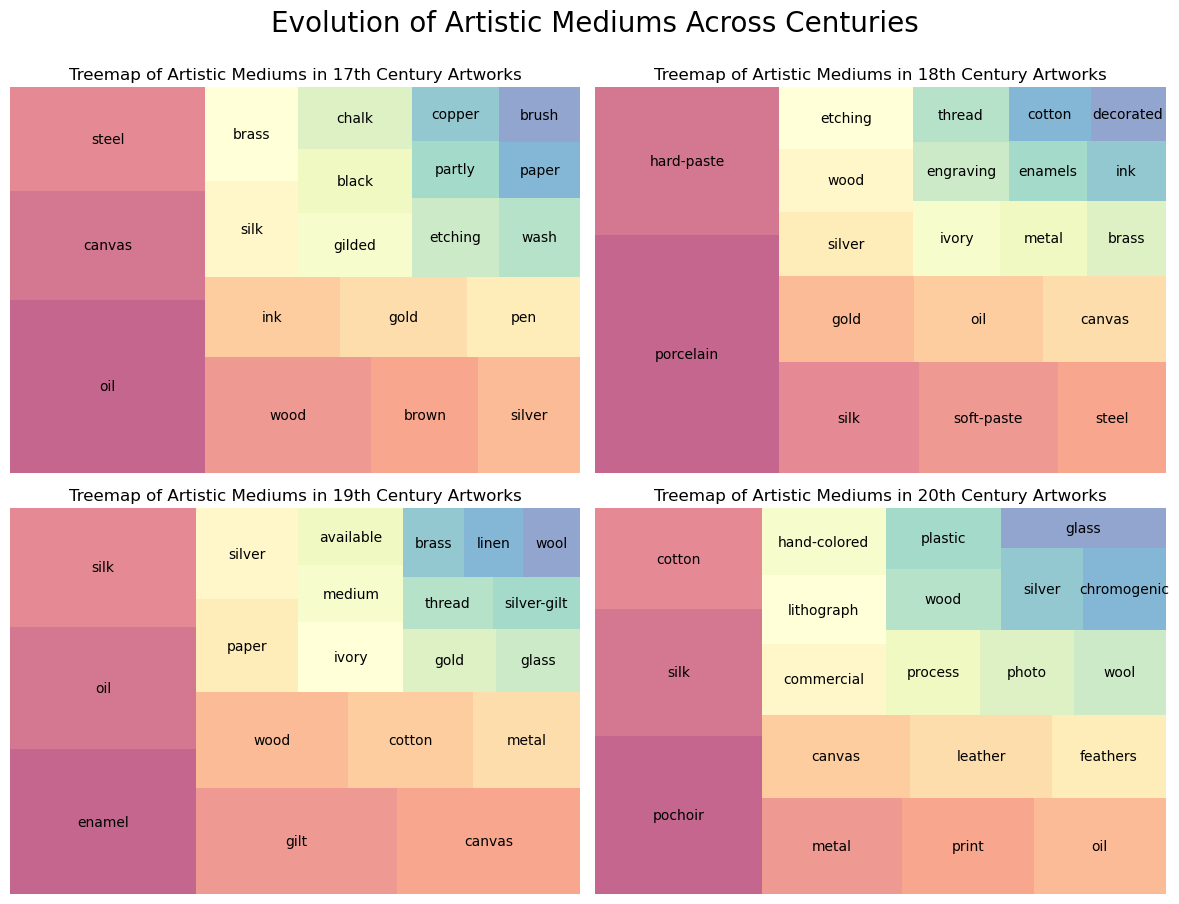

In [5]:
# Import additional library
import squarify

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')

# Define a set of stop words to be removed
stop_words = set(stopwords.words('english') + list(string.punctuation) + list(string.digits) +
                 ['your', 'long', 'list', 'of', 'words', '.', '..', '...', '....', '.....', '......', ').', '.,'])

# in this function, we tokenize, lowercase and removing unnecessary words in the 'medium' for text analysis
def process_text(medium_list):
    tokens = word_tokenize(" ".join(medium_list))
    return [word.lower() for word in tokens if word.lower() not in stop_words]




# in this function, we first get the frequency of words and then select the 20 most common words from 'medium' info
# for visualization. the reason for choosing only 20 words chosen is to avoid messy picture and to 
# identify the most popular medium used.

def plot_treemap(ax, tokens, title, num_words=20):
    freq_dist = FreqDist(tokens)
    most_common = freq_dist.most_common(num_words)
    # unpack the fre_dist and get words, count separately for analysis
    words, counts = zip(*most_common)
    
    # assign color for the each word in the treemap
    colors = [plt.cm.Spectral(i/len(counts)) for i in range(len(counts))]
    
    # plot treemap
    squarify.plot(sizes=counts, label=words, color=colors, alpha=0.6, ax=ax,
                 text_kwargs={'horizontalalignment': 'center'})
    
    
    ax.axis('off')
    ax.set_title(title)

    
# we create a dictionary to store century info and medium info.
century_mediums = {
    '17th Century': medium_17_century,
    '18th Century': medium_18_century,
    '19th Century': medium_19_century,
    '20th Century': medium_20_century
}

# Create a subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.flatten()



# we use enumerate to automatically provide index for each subplot.
#then we apply two function definded before to process text and draw treeplot
for i, (century, mediums) in enumerate(century_mediums.items()):
    ax = axes[i]
    tokens = process_text(mediums)
    plot_treemap(ax, tokens, f'Treemap of Artistic Mediums in {century} Artworks')
    
    
# a main title
plt.suptitle('Evolution of Artistic Mediums Across Centuries', fontsize=20, y=1) 

# Adjusting layout and display the plots
plt.tight_layout()
plt.show()